In [1]:
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 12.3 MB/s eta 0:00:00


In [2]:
import boto3
import botocore
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense

In [3]:
# Defining functions for updating git files
def runcmd(command):
  res = subprocess.run(command, shell=True, capture_output=True, text=True)
  print(res.stdout, res.stderr)

def copytogit():
  source = "drive/MyDrive/Colab\ Notebooks/createmodel.ipynb"
  dest = "github-private-learning/"
  res = subprocess.run(
      "cp %s %s" % (source, dest),
      cwd="/content",
      shell=True,
      capture_output=True,
      text=True
  )
  print(res.stdout, res.stderr)

def commitandpush(comment):
  runcmd("git add -u")
  runcmd("git commit -m \"%s\"" % comment)
  runcmd("git push origin main")

In [4]:
# Connect to GitHub for Colab
email = input("Input GitHub Email: ")
username = input("Input GitHub Username: ")
github_token = input("Access Token: ")
clear_output()

runcmd("git config --global user.email \"%s\"" % email)
runcmd("git config --global user.name \"%s\"" % username)
!git clone https://github.com/NahcoCZ/github-private-learning.git
%cd github-private-learning/
runcmd("git remote add origin https://%s:%s@github.com/NahcoCZ/github-private-learning.git" % (username, github_token))
runcmd("git remote set-url origin https://%s:%s@github.com/NahcoCZ/github-private-learning.git" % (username, github_token))

 
 
Cloning into 'github-private-learning'...
remote: Enumerating objects: 11738, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 11738 (delta 17), reused 33 (delta 4), pack-reused 11691
Receiving objects: 100% (11738/11738), 390.82 MiB | 41.39 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Updating files: 100% (11737/11737), done.
/content/github-private-learning
 fatal: remote origin already exists.

 


In [5]:
# Connect to google drive to update files
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Download the data files from AWS S3 Bucket if needed
session = boto3.Session(
    aws_access_key_id=input("Access Key: "),
    aws_secret_access_key=input("Secret Key: "),
    aws_session_token=input("Session Token: ")
)
s3 = session.client('s3')

# Clear output to prevent AWS credential leak
clear_output()

try:
    s3.download_file("lolipoppers-project", "npy/image_data.npy", "image_data.npy")
    s3.download_file("lolipoppers-project", "npy/label_data.npy", "label_data.npy")
    print('File downloaded successfully.')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '404':
        print('The file does not exist.')
    else:
        print('An error occurred while downloading the file:', e)

File downloaded successfully.


In [7]:
# Load downloaded data into numpy.ndarray
X = np.load("image_data.npy")
Y = np.load("label_data.npy")

# Declare label names and declaring functions for later use
label_names = [
    'Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney',
    'Crosswalk', 'Hydrant', 'Motorcycle', 'Other', 'Palm', 'Stair',
    'Traffic Light'
]


def decodeDataset(coded):
    return label_names[np.argmax(coded, axis=1)]


def decode(label):
    return label_names[np.argmax(label)]


def plotImage(img, label):
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(label)
    plt.imshow(img)
    plt.show()

In [8]:
# Split the training and testing data
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2)

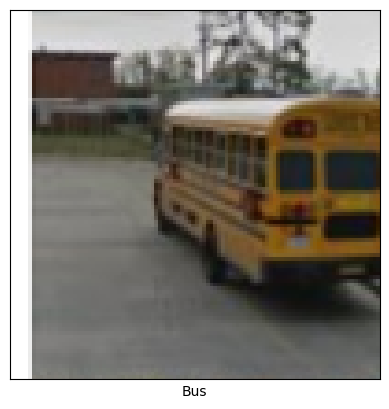

In [11]:
# Displaying one example from the dataset after splitting
plotImage(xtrain[0], decode(ytrain[0]))

In [43]:
# Defining compilation and training functions
def compile(model, epoch):
  # Compilation using adam optimization algorithm
  model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
  )
  history = model.fit(
    xtrain,
    ytrain,
    epochs=epoch,
    validation_data=(xtest, ytest)
  )
  return model, history

def setfigure():
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0, 1])
  plt.legend(loc='lower right')
  plt.show()

def evaluate(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  setfigure()

def checkmodel(model, epoch):
  result, hist = compile(model, epoch)
  evaluate(hist)
  test_loss, test_acc = result.evaluate(xtest, ytest, verbose=2)
  return result, hist

def comparegraph(hist1, hist2):
  hist = [hist1, hist2]
  for i in hist:
    plt.plot(i.history['accuracy'], label='accuracy')
  setfigure()

  for i in hist:
    plt.plot(i.history['val_accuracy'], label = 'val_accuracy')
  setfigure()

def compareacc(model1, model2):
  model1.evaluate(xtest, ytest, verbose=2)
  model2.evaluate(xtest, ytest, verbose=2)

In [ ]:
# Model Creation
firstModel = tf.keras.models.Sequential([
    # CNN Layers
    # 2D Convolution operation with 32 filters and 3x3 filter size
    # Smaller filter size will capture finer details on the image
    Conv2D(32, (3, 3), activation="relu", input_shape=(100, 100, 3)),
    # Max Pooling to reduce spatial dimension through 2x2 pooling window
    # Smaller pool size will capture more detail
    MaxPooling2D((2, 2)),
    # Adding more Convolution layers
    # filter count increased to capture more details and patterns
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((3, 3)),
    Conv2D(128, (3, 3), activation="relu"),
    # Convert to 1 dimensional array with Flatten
    Flatten(),
    # Use dense to capture the patterns and produce output
    Dense(64, activation="relu"),
    Dense(12)
])

Epoch 1/10
294/294 [==============================] - 17s 15ms/step - loss: 0.3511 - accuracy: 0.3411 - val_loss: 0.2222 - val_accuracy: 0.3994
Epoch 2/10
294/294 [==============================] - 3s 11ms/step - loss: 0.2138 - accuracy: 0.4388 - val_loss: 0.2162 - val_accuracy: 0.4356
Epoch 3/10
294/294 [==============================] - 3s 11ms/step - loss: 0.1880 - accuracy: 0.5244 - val_loss: 0.2054 - val_accuracy: 0.4983
Epoch 4/10
294/294 [==============================] - 3s 12ms/step - loss: 0.1639 - accuracy: 0.5946 - val_loss: 0.1930 - val_accuracy: 0.5171
Epoch 5/10
294/294 [==============================] - 3s 11ms/step - loss: 0.1345 - accuracy: 0.6833 - val_loss: 0.2284 - val_accuracy: 0.4893
Epoch 6/10
294/294 [==============================] - 3s 11ms/step - loss: 0.1090 - accuracy: 0.7629 - val_loss: 0.2265 - val_accuracy: 0.4932
Epoch 7/10
294/294 [==============================] - 3s 11ms/step - loss: 0.0816 - accuracy: 0.8426 - val_loss: 0.2670 - val_accuracy: 0.501

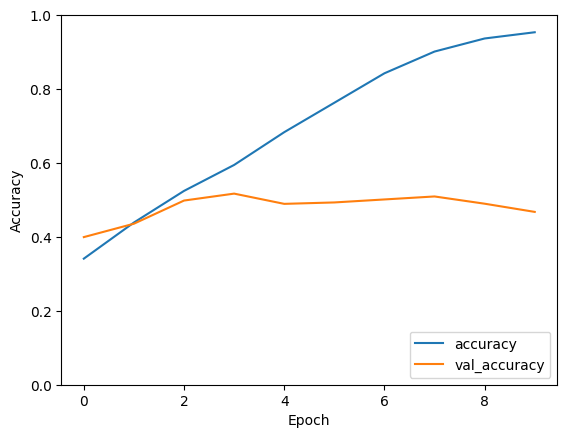

74/74 - 0s - loss: 0.3996 - accuracy: 0.4676 - 270ms/epoch - 4ms/step


In [ ]:
checkmodel(firstModel, 20)

In [33]:
#Second model
second_model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(12)
])

Epoch 1/10
294/294 [==============================] - 6s 14ms/step - loss: 0.4031 - accuracy: 0.3566 - val_loss: 0.2301 - val_accuracy: 0.3858
Epoch 2/10
294/294 [==============================] - 5s 15ms/step - loss: 0.2098 - accuracy: 0.4541 - val_loss: 0.2038 - val_accuracy: 0.4646
Epoch 3/10
294/294 [==============================] - 5s 16ms/step - loss: 0.1875 - accuracy: 0.5283 - val_loss: 0.1970 - val_accuracy: 0.5149
Epoch 4/10
294/294 [==============================] - 5s 18ms/step - loss: 0.1709 - accuracy: 0.5765 - val_loss: 0.1987 - val_accuracy: 0.5158
Epoch 5/10
294/294 [==============================] - 4s 12ms/step - loss: 0.1582 - accuracy: 0.6142 - val_loss: 0.1930 - val_accuracy: 0.5290
Epoch 6/10
294/294 [==============================] - 4s 13ms/step - loss: 0.1438 - accuracy: 0.6570 - val_loss: 0.1940 - val_accuracy: 0.5175
Epoch 7/10
294/294 [==============================] - 6s 20ms/step - loss: 0.1248 - accuracy: 0.7137 - val_loss: 0.2227 - val_accuracy: 0.4928

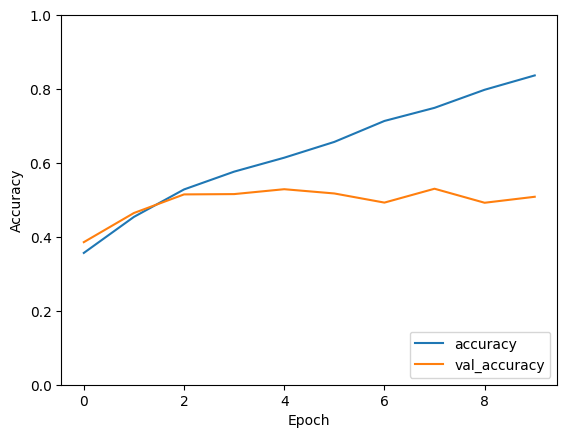

74/74 - 0s - loss: 0.2626 - accuracy: 0.5085 - 384ms/epoch - 5ms/step


In [34]:
model2, history2 = checkmodel(second_model, 10)

Epoch 1/10
294/294 [==============================] - 12s 27ms/step - loss: 0.2723 - accuracy: 0.2972 - val_loss: 0.2541 - val_accuracy: 0.3090
Epoch 2/10
294/294 [==============================] - 7s 24ms/step - loss: 0.2306 - accuracy: 0.3712 - val_loss: 0.2257 - val_accuracy: 0.4084
Epoch 3/10
294/294 [==============================] - 7s 25ms/step - loss: 0.2063 - accuracy: 0.4461 - val_loss: 0.1928 - val_accuracy: 0.4945
Epoch 4/10
294/294 [==============================] - 8s 26ms/step - loss: 0.1859 - accuracy: 0.5193 - val_loss: 0.1913 - val_accuracy: 0.5043
Epoch 5/10
294/294 [==============================] - 9s 30ms/step - loss: 0.1740 - accuracy: 0.5514 - val_loss: 0.1927 - val_accuracy: 0.5030
Epoch 6/10
294/294 [==============================] - 7s 24ms/step - loss: 0.1627 - accuracy: 0.5837 - val_loss: 0.1700 - val_accuracy: 0.5588
Epoch 7/10
294/294 [==============================] - 8s 26ms/step - loss: 0.1514 - accuracy: 0.6211 - val_loss: 0.1792 - val_accuracy: 0.524

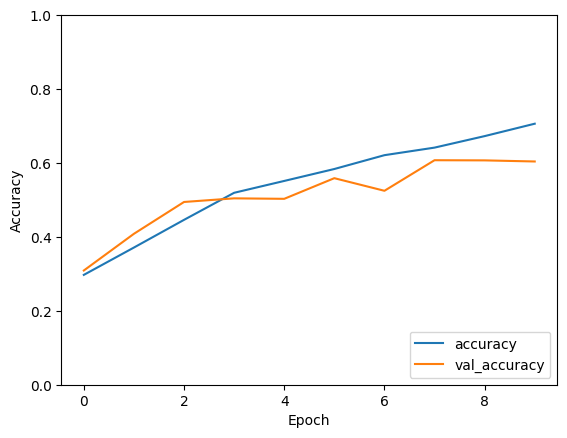

74/74 - 1s - loss: 0.1635 - accuracy: 0.6040 - 514ms/epoch - 7ms/step


In [35]:
#Third model
third_model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(100, 100, 3)),
    Conv2D(32, (3, 3), activation="relu"),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D((2, 2), strides=(3, 3)),

    Conv2D(64, (3, 3), activation="relu"),
    Conv2D(64, (3, 3), activation="relu"),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2), strides=(3, 3)),

    Conv2D(128, (3, 3), activation="relu"),
    Conv2D(128, (3, 3), activation="relu"),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2), strides=(3, 3)),

    # Conv2D(128, (3, 3), activation="relu"),
    # Conv2D(128, (3, 3), activation="relu"),
    # MaxPooling2D((2, 2), strides=(3, 3)),

    Flatten(),
    Dense(64, activation="relu"),
    Dense(12)
])
model3, history3 = checkmodel(third_model, 10)

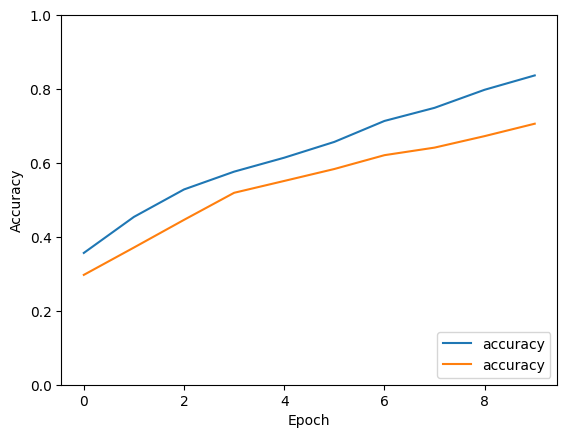

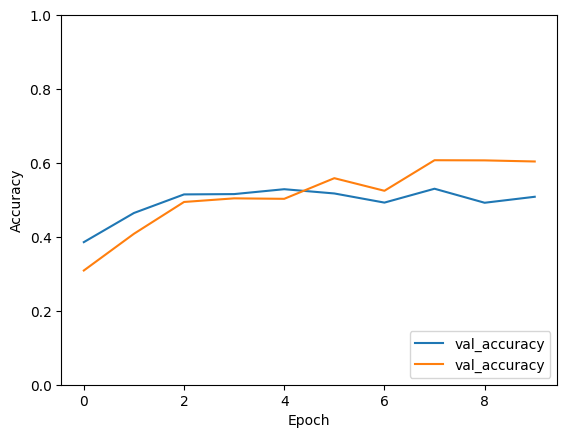

74/74 - 0s - loss: 0.2626 - accuracy: 0.5085 - 398ms/epoch - 5ms/step
74/74 - 1s - loss: 0.1635 - accuracy: 0.6040 - 574ms/epoch - 8ms/step


In [44]:
comparegraph(history2, history3)
compareacc(model2, model3)

In [ ]:
# Commit changes
copytogit()
commitandpush(input("Insert Commit Comment: "))

 
Insert Commit Comment: Removed unused testing codes
 
[main 903da4c] Removed unused testing codes
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite createmodel.ipynb (94%)
 
 remote: Resolving deltas:   0% (0/1)        
remote: Resolving deltas: 100% (1/1)        
remote: Resolving deltas: 100% (1/1), completed with 1 local object.        
To https://github.com/NahcoCZ/github-private-learning.git
   b844721..903da4c  main -> main

